# Ensemble selection for historical temperature attribution

Theme Song: Come As You Are<br>
Artist: Nirvana<br>
Album: Nevermind<br>
Year: 1991

- Run two layer model with AR6 forcing, but using constrained-correlated parameter setups
- Use constrained FaIR setup from 056 and 057 
- This also gets passed on to chapter 9

In [1]:
import fair
import json
import sys
import os
import random
import numpy as np
import scipy.stats as st       # v1.4+ needed
import matplotlib.pyplot as pl
import pandas as pd
from multiprocessing import Pool

from ar6.utils.h5 import *
from ar6.forcing.aerosol import aerocom_n, ghan
from ar6.twolayermodel import TwoLayerModel
from ar6.constants import NINETY_TO_ONESIGMA

from netCDF4 import Dataset
from tqdm import tqdm_notebook
from scipy.interpolate import interp1d

from tqdm.notebook import tqdm

## Ensemble generation

We want to ensure reproducible results that don't change when this script is re-run. Grab list of pre-generated random seeds.

In [2]:
with open('../data_input/random_seeds.json', 'r') as filehandle:
    SEEDS = json.load(filehandle)

In [3]:
emissions = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
df_emissions = pd.concat([emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')|
        (emissions.Variable=='Emissions|VOC')|
        (emissions.Variable=='Emissions|CO')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), 'Variable'], emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')|
        (emissions.Variable=='Emissions|VOC')|
        (emissions.Variable=='Emissions|CO')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
df_emissions.rename(
    columns={
        'Emissions|BC': 'BC',
        'Emissions|OC': 'OC',
        'Emissions|Sulfur': 'SO2',
        'Emissions|NOx': 'NOx',
        'Emissions|NH3': 'NH3',
        'Emissions|VOC': 'VOC',
        'Emissions|CO': 'CO'
    }, inplace=True
)
# only keep cols we want
emissions = df_emissions[['SO2', 'BC', 'OC', 'NH3', 'NOx', 'VOC', 'CO']]
emissions.index = emissions.index.astype('int')
emissions.index.name='year'
emissions.columns.name=None

emissions_ceds_update = emissions.copy()

emissions_old = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
df_emissions = pd.concat([emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|CO|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|CO|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), 'Variable'], emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|CO|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|CO|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
for species in ['BC', 'OC', 'Sulfur', 'NOx', 'NH3', 'VOC', 'CO']:
    df_emissions[species] = df_emissions['Emissions|{}|MAGICC Fossil and Industrial'.format(species)] + df_emissions['Emissions|{}|MAGICC AFOLU|Agriculture'.format(species)]
df_emissions.rename(columns = {'Sulfur': 'SO2'}, inplace=True)
df_emissions.drop(columns=[
        'Emissions|BC|MAGICC Fossil and Industrial',
        'Emissions|OC|MAGICC Fossil and Industrial',
        'Emissions|Sulfur|MAGICC Fossil and Industrial',
        'Emissions|NOx|MAGICC Fossil and Industrial',
        'Emissions|NH3|MAGICC Fossil and Industrial',
        'Emissions|VOC|MAGICC Fossil and Industrial',
        'Emissions|CO|MAGICC Fossil and Industrial',
        'Emissions|BC|MAGICC AFOLU|Agriculture',
        'Emissions|OC|MAGICC AFOLU|Agriculture',
        'Emissions|Sulfur|MAGICC AFOLU|Agriculture',
        'Emissions|NOx|MAGICC AFOLU|Agriculture',
        'Emissions|NH3|MAGICC AFOLU|Agriculture',
        'Emissions|VOC|MAGICC AFOLU|Agriculture',
        'Emissions|CO|MAGICC AFOLU|Agriculture',
    ],
    inplace=True
)
df_emissions.index = emissions.index.astype('int')
df_emissions.index.name='year'
df_emissions.columns.name=None

global_total = {}
for species in ['BC', 'OC', 'SO2', 'NH3', 'NOx', 'NMVOC', 'CO']:
    df = pd.read_csv('../data_input_large/CEDS_v_2020_09_11_emissions/{}_global_CEDS_emissions_by_sector_2020_09_11.csv'.format(species))
    global_total[species] = df.sum(axis=0).values[3:].astype(float) / 1000 
    #unit = df.units[0]
    #print(unit)
global_total['VOC'] = global_total.pop('NMVOC')
new_ceds = pd.DataFrame(global_total)
new_ceds.index = np.arange(1750,2020)
new_ceds.index = new_ceds.index.astype('int')
new_ceds.index.name='year'
new_ceds.columns.name=None
emissions_ceds_update = new_ceds.loc[1750:2020] + emissions - df_emissions
emissions_ceds_update.drop(index=range(2020,2101), inplace=True)
emissions_ceds_update

,BC,CO,NH3,NOx,OC,SO2,VOC
year,,,,,,,
1750,2.097336,348.420476,6.683996,12.730074,15.447054,2.312083,60.599376
1751,2.072491,343.819148,6.615537,12.587160,15.188102,2.281498,59.667759
1752,2.063877,341.701465,6.573965,12.589121,15.033861,2.270899,59.213713
1753,2.071515,343.567551,6.635011,12.534665,15.181930,2.284976,59.610148
1754,2.098914,349.707369,6.767852,12.631676,15.558158,2.336934,60.855827
...,...,...,...,...,...,...,...
2015,7.992567,894.144647,62.462922,138.718989,30.046634,91.076152,213.006570
2016,7.918346,874.700320,63.054904,137.128483,30.086767,87.215738,211.778440
2017,7.886938,867.879243,63.739495,137.159668,30.057079,84.269791,211.717165


## Climate model parameters

### load unconstrained

In [4]:
# ozone
ozone_feedback = np.load('../data_input_large/fair-samples/ozone_feedback_unconstrained.npy')
beta_ch4 = np.load('../data_input_large/fair-samples/beta_ch4_unconstrained.npy')
beta_n2o = np.load('../data_input_large/fair-samples/beta_n2o_unconstrained.npy')
beta_ods = np.load('../data_input_large/fair-samples/beta_ods_unconstrained.npy')
beta_co = np.load('../data_input_large/fair-samples/beta_co_unconstrained.npy')
beta_voc = np.load('../data_input_large/fair-samples/beta_voc_unconstrained.npy')
beta_nox = np.load('../data_input_large/fair-samples/beta_nox_unconstrained.npy')

# carbon cycle
r0 = np.load('../data_input_large/fair-samples/r0_unconstrained.npy')
rC = np.load('../data_input_large/fair-samples/rC_unconstrained.npy')
rT = np.load('../data_input_large/fair-samples/rT_unconstrained.npy')
pre_ind_co2 = np.load('../data_input_large/fair-samples/pre_ind_co2_unconstrained.npy')

# aerosol
beta_so2 = np.load('../data_input_large/fair-samples/beta_so2_unconstrained.npy')
beta_bc = np.load('../data_input_large/fair-samples/beta_bc_unconstrained.npy')
beta_oc = np.load('../data_input_large/fair-samples/beta_oc_unconstrained.npy')
beta_nh3 = np.load('../data_input_large/fair-samples/beta_nh3_unconstrained.npy')
beta = np.load('../data_input_large/fair-samples/beta_unconstrained.npy')
aci_coeffs = np.load('../data_input_large/fair-samples/aci_coeffs.npy')

# forcing
scale_normals = np.load('../data_input_large/fair-samples/scale_normals.npy')
trend_solar = np.load('../data_input_large/fair-samples/scale_trend_solar.npy')

# climate response
geoff_sample_df = pd.read_csv('../data_output_large/geoff_sample.csv', index_col=0)
f2x = np.load('../data_input_large/fair-samples/f2x_unconstrained.npy')
ecs = np.load('../data_input_large/fair-samples/ecs_unconstrained.npy')
tcr = np.load('../data_input_large/fair-samples/tcr_unconstrained.npy')

# accepted ensemble
accept_inds = np.loadtxt('../data_output_large/fair-samples/accept_inds.csv', dtype=int)

### apply the constraint and overwrite unconstrained

In [5]:
accept_inds

array([   156,    358,    441, ..., 998289, 998908, 999021])

In [6]:
geoff_sample_df.loc[accept_inds]

,q4x,lamg,cmix,cdeep,gamma_2l,eff
156,6.419499,-1.714643,8.810878,448.213437,0.440273,0.347264
358,8.646745,-1.817834,9.691545,103.494497,0.772469,1.585394
441,8.316302,-2.085561,5.696549,180.474488,0.821490,1.251474
636,7.889668,-0.796998,7.735094,89.445554,0.852359,1.535440
914,7.034846,-1.315331,8.992672,168.484833,0.709503,1.100228
...,...,...,...,...,...,...
996792,7.585270,-1.281183,8.745431,62.417455,0.755601,1.668154
996846,7.574501,-1.881943,9.089493,452.306881,0.565309,0.532951
998289,7.528928,-1.436389,7.878012,109.737561,0.522615,1.350649
998908,8.727801,-1.409111,9.221984,128.496448,0.521846,1.581632


In [7]:
df_solar = pd.read_csv('../data_output/solar_erf.csv', index_col='year')
solar_forcing = df_solar.solar_erf.loc[1750:2019].values

df_volcanic = pd.read_csv('../data_output/volcanic_erf.csv', index_col='year')
volcanic_forcing = np.zeros((270))
volcanic_forcing[:269] = df_volcanic.volcanic_erf.loc[1750:2018].values
# ramp down last 10 years to zero according to https://www.geosci-model-dev.net/9/3461/2016/gmd-9-3461-2016.html
volcanic_forcing[269] = volcanic_forcing[268]

In [8]:
# ozone
ozone_feedback = ozone_feedback[accept_inds]
beta_ch4 = beta_ch4[accept_inds]
beta_n2o = beta_n2o[accept_inds]
beta_ods = beta_ods[accept_inds]
beta_co = beta_co[accept_inds]
beta_voc = beta_voc[accept_inds]
beta_nox = beta_nox[accept_inds]

# carbon cycle
pre_ind_co2 = pre_ind_co2[accept_inds]
r0 = r0[accept_inds]
rC = rC[accept_inds]
rT = rT[accept_inds]

# aerosol
beta_so2 = beta_so2[accept_inds]
beta_bc = beta_bc[accept_inds]
beta_oc = beta_oc[accept_inds]
beta_nh3 = beta_nh3[accept_inds]
beta = beta[accept_inds]
aci_coeffs = aci_coeffs[accept_inds]

# forcing
scale_normals = scale_normals[accept_inds]
trend_solar = trend_solar[accept_inds]

# climate response
geoff_sample_df = geoff_sample_df.loc[accept_inds]
f2x = f2x[accept_inds]
ecs = ecs[accept_inds]
tcr = tcr[accept_inds]

In [9]:
f2x_median = np.median(f2x)
ecs_median = np.median(ecs)
tcr_median = np.median(tcr)

(array([121., 574., 807., 474., 185.,  37.,  10.,  16.,  10.,   3.]),
 array([6.80758831e-04, 3.38060015e-01, 6.75439272e-01, 1.01281853e+00,
        1.35019778e+00, 1.68757704e+00, 2.02495630e+00, 2.36233555e+00,
        2.69971481e+00, 3.03709407e+00, 3.37447332e+00]),
 <a list of 10 Patch objects>)

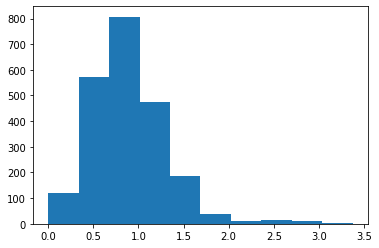

In [10]:
kappa = f2x/tcr - f2x/ecs
# kappa = efficacy * eta
pl.hist(kappa)

In [11]:
lamg = geoff_sample_df['lamg'].values
eff = geoff_sample_df['eff'].values
gamma_2l = geoff_sample_df['gamma_2l'].values
cdeep = geoff_sample_df['cdeep'].values
cmix = geoff_sample_df['cmix'].values

## Forcing uncertainties - ensure consistency with 040

### Aerosol emissions

In [12]:
ERFari = np.zeros((270, len(accept_inds)))
ERFaci = np.zeros((270, len(accept_inds)))

so2 = emissions_ceds_update.loc[:,'SO2']
bc = emissions_ceds_update.loc[:,'BC']
oc = emissions_ceds_update.loc[:,'OC']
nh3 = emissions_ceds_update.loc[:,'NH3']

for i in tqdm(range(len(accept_inds))):
    ERFari[:, i] = (
        (emissions_ceds_update.loc[:,'SO2']-emissions_ceds_update.loc[1750,'SO2']) * beta_so2[i] * 32/64 +
        (emissions_ceds_update.loc[:,'BC']-emissions_ceds_update.loc[1750,'BC']) * beta_bc[i] +
        (emissions_ceds_update.loc[:,'OC']-emissions_ceds_update.loc[1750,'OC']) * beta_oc[i] +
        (emissions_ceds_update.loc[:,'NH3']-emissions_ceds_update.loc[1750,'NH3']) * beta_nh3[i]
    )
    
    ERFaci[:,i] = ghan([so2 * 32/64, bc+oc], beta[i], aci_coeffs[i,0], aci_coeffs[i,1]) - ghan([so2[1750] * 32/64, bc[1750]+oc[1750]], beta[i], aci_coeffs[i,0], aci_coeffs[i,1])

  0%|          | 0/2237 [00:00<?, ?it/s]

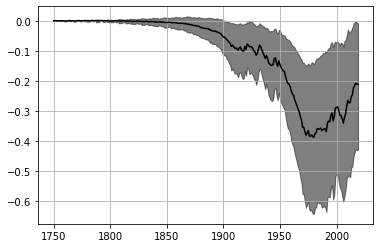

In [13]:
pl.fill_between(np.arange(1750, 2020), np.percentile(ERFari, 5, axis=1), np.percentile(ERFari, 95, axis=1), color='k', alpha=0.5)
pl.plot(np.arange(1750,2020), np.percentile(ERFari, 50, axis=1), color='k')
pl.grid()

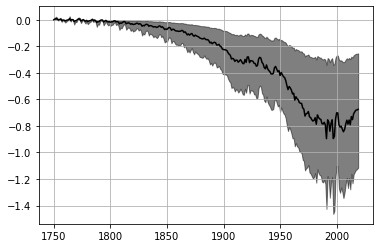

In [14]:
pl.fill_between(np.arange(1750, 2020), np.percentile(ERFaci, 5, axis=1), np.percentile(ERFaci, 95, axis=1), color='k', alpha=0.5)
pl.plot(np.arange(1750,2020), np.percentile(ERFaci, 50, axis=1), color='k')
pl.grid()

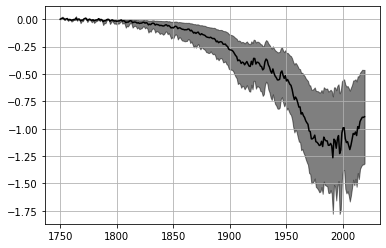

In [15]:
pl.fill_between(np.arange(1750, 2020), np.percentile(ERFari+ERFaci, 5, axis=1), np.percentile(ERFari+ERFaci, 95, axis=1), color='k', alpha=0.5)
pl.plot(np.arange(1750,2020), np.percentile(ERFari+ERFaci, 50, axis=1), color='k')
pl.grid()

### Non-aerosol forcings and aggregated categories

In [16]:
scale_normals.shape

(2237, 11)

In [17]:
df = pd.read_csv('../data_output/AR6_ERF_1750-2019.csv')
forcing_ensemble = {}
for cat in ['co2', 'ch4', 'n2o', 'other_wmghg', 'o3', 'h2o_stratospheric', 'contrails', 'aerosol-radiation_interactions',
           'aerosol-cloud_interactions', 'bc_on_snow', 'land_use', 'solar', 'volcanic', 'wmghgs', 'aerosol', 'albedo',
           'anthro', 'natural']:
    forcing_ensemble[cat] = np.zeros((8775, len(accept_inds)))
    
forcing_ensemble['co2'][8505:,:] = df['co2'].values[:,None] * scale_normals[:,0]
forcing_ensemble['ch4'][8505:,:] = df['ch4'].values[:,None] * scale_normals[:,1]
forcing_ensemble['n2o'][8505:,:] = df['n2o'].values[:,None] * scale_normals[:,2]
forcing_ensemble['other_wmghg'][8505:,:] = df['other_wmghg'].values[:,None] * scale_normals[:,3]
forcing_ensemble['o3'][8505:,:] = df['o3'].values[:,None] * scale_normals[:,4]
forcing_ensemble['h2o_stratospheric'][8505:,:] = df['h2o_stratospheric'].values[:,None] * scale_normals[:,5]
forcing_ensemble['contrails'][8505:,:] = df['contrails'].values[:,None] * scale_normals[:,6]
forcing_ensemble['aerosol-radiation_interactions'][8505:,:] = ERFari
forcing_ensemble['aerosol-cloud_interactions'][8505:,:] = ERFaci
forcing_ensemble['bc_on_snow'][8505:,:] = df['bc_on_snow'].values[:,None] * scale_normals[:,7]
forcing_ensemble['land_use'][8505:,:] = df['land_use'].values[:,None] * scale_normals[:,8]
forcing_ensemble['volcanic'][6255:8505,:] = df_volcanic.volcanic_erf.loc[:1749].values[:,None] * scale_normals[:,9]
forcing_ensemble['volcanic'][8505:,:] = df['volcanic'].values[:,None] * scale_normals[:,9]
forcing_ensemble['solar'][:8505,:] = df_solar.solar_erf.loc[:1749].values[:,None] * scale_normals[:,10]
forcing_ensemble['solar'][8505:,:] = np.linspace(0,trend_solar,270) + df['solar'].values[:,None] * scale_normals[:,10]
forcing_ensemble['wmghgs'] = (
    forcing_ensemble['co2'] +
    forcing_ensemble['ch4'] +
    forcing_ensemble['n2o'] +
    forcing_ensemble['other_wmghg']
)
forcing_ensemble['aerosol'] = (
    forcing_ensemble['aerosol-radiation_interactions'] +
    forcing_ensemble['aerosol-cloud_interactions']
)
forcing_ensemble['albedo'] = (
    forcing_ensemble['bc_on_snow'] +
    forcing_ensemble['land_use']
)
forcing_ensemble['natural'] = (
    forcing_ensemble['volcanic'] +
    forcing_ensemble['solar']
)
forcing_ensemble['anthro'] = (
    forcing_ensemble['co2'] +
    forcing_ensemble['ch4'] +
    forcing_ensemble['n2o'] +
    forcing_ensemble['other_wmghg'] +
    forcing_ensemble['o3'] +
    forcing_ensemble['h2o_stratospheric'] +
    forcing_ensemble['contrails'] +
    forcing_ensemble['aerosol-radiation_interactions'] +
    forcing_ensemble['aerosol-cloud_interactions'] +
    forcing_ensemble['bc_on_snow'] +
    forcing_ensemble['land_use']
)
forcing_ensemble['total'] = (
    forcing_ensemble['co2'] +
    forcing_ensemble['ch4'] +
    forcing_ensemble['n2o'] +
    forcing_ensemble['other_wmghg'] +
    forcing_ensemble['o3'] +
    forcing_ensemble['h2o_stratospheric'] +
    forcing_ensemble['contrails'] +
    forcing_ensemble['aerosol-radiation_interactions'] +
    forcing_ensemble['aerosol-cloud_interactions'] +
    forcing_ensemble['bc_on_snow'] +
    forcing_ensemble['land_use'] +
    forcing_ensemble['volcanic'] +
    forcing_ensemble['solar']
)

In [18]:
forcing_ensemble['total'][:,0].shape

(8775,)

# Run climate model

- should use assessed rather than constrained ranges I guess

In [19]:
with open('../data_input/tunings/cmip6_twolayer_tuning_params.json', 'r') as filehandle:
    cmip6_models = json.load(filehandle)

In [20]:
cmix_mean = cmip6_models['cmix']['mean']['EBM-epsilon']
cdeep_mean = cmip6_models['cdeep']['mean']['EBM-epsilon']
eff_mean = cmip6_models['eff']['mean']['EBM-epsilon']

lamg_median = f2x_median/ecs_median
kappa_median = -(f2x_median/ecs_median - f2x_median/tcr_median)
gamma_2l_median = kappa_median/eff_mean

In [21]:
gamma_2l_median, kappa_median, lamg_median, eff_mean, cmix_mean, cdeep_mean

(0.6395952745483992,
 0.85785768256684,
 1.3670409092103908,
 1.3412508139190835,
 8.144224615560551,
 109.62536045769089)

In [22]:
results = {}

## 9000-year forcing runs

- all forcing
- gives us 1750 temperatures
- save only 1750-2019

In [23]:
6755+1750

8505

In [24]:
arglist=[]
for i in range(len(accept_inds)):
    arglist.append(
        {
            'in_forcing' : forcing_ensemble['total'][:,i],
            'firstyear': -6755
        }
    )
def run_tlm(args):
    in_forcing = args['in_forcing']
    driver = TwoLayerModel(
        extforce=in_forcing,
        exttime=np.arange(args['firstyear'],2020),
        tbeg=args['firstyear'],
        tend=2020,
        lamg=lamg_median,
        t2x=None,
        eff=eff_mean,
        cmix=cmix_mean,
        cdeep=cdeep_mean,
        gamma_2l=gamma_2l_median,
        outtime=np.arange(1750,2020),
        dt=0.2
    )
    output = driver.run()
    return(output.tg)

    
if __name__ == '__main__':
    with Pool(24) as pool:
        result = list(tqdm(pool.imap(run_tlm, arglist), total=len(accept_inds)))
    output = np.array(result).T

  0%|          | 0/2237 [00:00<?, ?it/s]

In [25]:
results['AR6-historical'] = {}
results['AR6-historical']['effective_radiative_forcing'] = forcing_ensemble['total'][8505:,:]
results['AR6-historical']['surface_temperature'] = output

## Marginal contributions since 1750

- forcing variation only
- include aggregated categories: all WMGHG, all aerosol, all albedo, all anthropogenic, all natural

In [26]:
if __name__ == '__main__':
    for agent in tqdm(list(forcing_ensemble.keys())[:-1], desc='Removing one at a time'):
        arglist = []
        startindex = 0
        firstyear = -6755
        for i in range(len(accept_inds)):
            in_forcing = forcing_ensemble['total'][startindex:,i] - forcing_ensemble[agent][startindex:,i]
            arglist.append(
                {
                    'in_forcing' : in_forcing,
                    'firstyear': firstyear
                }
            )

        results['remove_%s' % agent] = {}
        with Pool(24) as pool:
            result = list(tqdm(pool.imap(run_tlm, arglist), total=len(accept_inds), leave=False))
        output = np.array(result).T

        results['remove_%s' % agent]['effective_radiative_forcing'] = forcing_ensemble['total'][8505:,:]-forcing_ensemble[agent][8505:,:]
        results['remove_%s' % agent]['surface_temperature'] = output

Removing one at a time:   0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

(array([  7.,  45., 136., 323., 534., 565., 365., 188.,  57.,  17.]),
 array([-0.18853572, -0.0847    ,  0.01913572,  0.12297144,  0.22680716,
         0.33064288,  0.4344786 ,  0.53831432,  0.64215004,  0.74598576,
         0.84982148]),
 <a list of 10 Patch objects>)

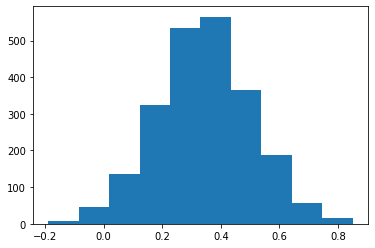

In [27]:
pl.hist(results['remove_co2']['surface_temperature'][-1,:])

(array([  5.,  48., 144., 337., 537., 566., 349., 191.,  43.,  17.]),
 array([-0.26843642, -0.16372385, -0.05901127,  0.04570131,  0.15041388,
         0.25512646,  0.35983904,  0.46455161,  0.56926419,  0.67397677,
         0.77868934]),
 <a list of 10 Patch objects>)

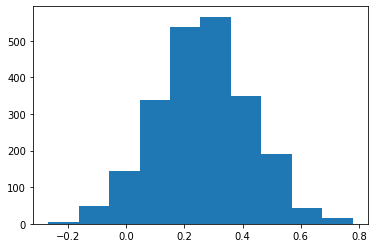

In [28]:
pl.hist(results['remove_co2']['surface_temperature'][-1,:] - results['remove_co2']['surface_temperature'][0,:])

## 9000-year forcing runs

- forcing and climate variation

In [29]:
arglist = []

lamg = -geoff_sample_df['lamg'].values
eff = geoff_sample_df['eff'].values
gamma_2l = geoff_sample_df['gamma_2l'].values
cdeep = geoff_sample_df['cdeep'].values
cmix = geoff_sample_df['cmix'].values


for i in range(len(accept_inds)):
    arglist.append(
        {
            'cmix': cmix[i],
            'cdeep': cdeep[i],
            'gamma_2l': gamma_2l[i],
            'lamg': lamg[i],
            'eff': eff[i],
            'in_forcing' : forcing_ensemble['total'][:,i],
            'firstyear': -6755
        }
    )

results['AR6-historical_climuncert'] = {}

def run_tlm(args):
    in_forcing = args['in_forcing']
    driver = TwoLayerModel(
        extforce=in_forcing,
        exttime=np.arange(args['firstyear'],2020),
        tbeg=args['firstyear'],
        tend=2020,
        lamg=args['lamg'],
        t2x=None,
        eff=args['eff'],
        cmix=args['cmix'],
        cdeep=args['cdeep'],
        gamma_2l=args['gamma_2l'],
        outtime=np.arange(1750,2020),
        dt=0.2
    )
    output = driver.run()
    return(
        output.tg,
        output.tlev[:,1],
        output.hflux,
        output.ohc
    )
    
    
if __name__ == '__main__':
    with Pool(24) as pool:
        result = list(tqdm(pool.imap(run_tlm, arglist), total=len(accept_inds)))
    output = np.array(result).T

  0%|          | 0/2237 [00:00<?, ?it/s]

In [31]:
# I don't know why I decided to add in the non-surface temperature variables at different stages of this repository evolution
# but it's now throwing off results in 220 and 230 : CS, 04.10.2021

# first check shape of results array
output.shape

(270, 4, 2237)

In [32]:
results['AR6-historical_climuncert']['effective_radiative_forcing'] = forcing_ensemble['total'][8505:,:]
results['AR6-historical_climuncert']['surface_temperature'] = output[:,0,:]
results['AR6-historical_climuncert']['deep_ocean_temperature'] = output[:,1,:]
results['AR6-historical_climuncert']['toa_energy_imbalance'] = output[:,2,:]
results['AR6-historical_climuncert']['integrated_toa_energy_imbalance'] = output[:,3,:]

## Marginal contributions since 1750

- forcing and climate variation
- include aggregated categories: all WMGHG, all aerosol, all albedo, all anthropogenic, all natural

In [37]:
if __name__ == '__main__':
    for agent in tqdm(list(forcing_ensemble.keys())[:-1], desc='Removing one at a time'):
        arglist = []
        for i in range(len(accept_inds)):
            startindex=0
            firstyear = -6755
            in_forcing = forcing_ensemble['total'][startindex:,i] - forcing_ensemble[agent][startindex:,i]
            arglist.append(
                {
                    'in_forcing' : in_forcing,
                    'cmix': cmix[i],
                    'cdeep': cdeep[i],
                    'gamma_2l': gamma_2l[i],
                    'lamg': lamg[i],
                    'eff': eff[i],
                    'firstyear': firstyear
                }
            )
        output = []
        results['remove_%s_climuncert' % agent] = {}
        with Pool(24) as pool:
            result = list(tqdm(pool.imap(run_tlm, arglist), total=len(accept_inds), leave=False))
        output = np.array(result).T

        results['remove_%s_climuncert' % agent]['effective_radiative_forcing'] = forcing_ensemble['total'][8505:,:] - forcing_ensemble[agent][8505:,:]
        results['remove_%s_climuncert' % agent]['surface_temperature'] = output[:,0,:]
        results['remove_%s_climuncert' % agent]['deep_ocean_temperature'] = output[:,1,:]
        results['remove_%s_climuncert' % agent]['toa_energy_imbalance'] = output[:,2,:]
        results['remove_%s_climuncert' % agent]['integrated_toa_energy_imbalance'] = output[:,3,:]

Removing one at a time:   0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

In [38]:
save_dict_to_hdf5(results, '../data_output_large/twolayer_AR6-historical.h5')